In [1]:
import json
from pathlib import Path
from typing import List, Optional
from zipfile import ZipFile

import liblzfse
import numpy as np
import open3d as o3d
import tqdm
from PIL import Image
from quaternion import as_rotation_matrix, quaternion
from torch.utils.data import Dataset

import sys
sys.path.append('..')
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from dataloaders.scannet_200_classes import CLASS_LABELS_200

INFO - 2023-06-13 04:53:44,737 - font_manager - generated new fontManager


In [3]:
class MyDataset(Dataset):
    
    def __init__(self, num, custom_classes: Optional[List[str]] = CLASS_LABELS_200):
        self.image_lis, self.depth_lis, self.world_lis, self.conf_lis = [], [], [], []
        self.num = num
        image = np.load('../data/image000.npy')
        self.image_size = (image.shape[1], image.shape[0])
        if custom_classes:
            self._classes = custom_classes
        else:
            self._classes = CLASS_LABELS_200
            
        self._id_to_name = {i: x for (i, x) in enumerate(self._classes)}
        
        for i in range(self.num+1):
            num = '000' + str(i)
            num = num[-3:]
            image = np.load('../data/image'+num+'.npy').astype(np.uint8)
            depth = (np.load('../data/depth'+num+'.npy')*0.001).astype(np.float32)
            mask = ~np.isnan(depth) #& (depth < 3.0)
            self.image_lis.append(image)
            self.depth_lis.append(depth)
            self.conf_lis.append(np.ones_like(depth)*2)

            #depth = depth[mask]
            # depth = cv2.convertScaleAbs(np.load('../data/depth'+num+'.npy')).astype(np.uint8)
            world = np.load('../data/world'+num+'.npy').reshape(-1, 3).astype(np.float64)
            self.world_lis.append(world)

    def __len__(self):
        return self.num
    
    def __getitem__(self, idx):
        result = {
            "xyz_position": self.world_lis[idx],
            "rgb": self.image_lis[idx],
            "depth": self.depth_lis[idx],
            "conf": self.conf_lis[idx],
        }
        
        return result

In [4]:
CUSTOM_LABELS = [
    "kitchen counter",
    "kitchen cabinet",
    "stove",
    "cabinet",
    "bathroom counter",
    "refrigerator",
    "microwave",
    "oven",
    "fireplace",
    "door",
    "sink",
    "furniture",
    "dish rack",
    "dining table",
    "shelf",
    "bar",
    "dishwasher",
    "toaster oven",
    "toaster",
    "mini fridge",
    "soap dish",
    "coffee maker",
    "table",
    "bowl",
    "rack",
    "bulletin board",
    "water cooler",
    "coffee kettle",
    "lamp",
    "plate",
    "window",
    "dustpan",
    "trash bin",
    "ceiling",
    "doorframe",
    "trash can",
    "basket",
    "wall",
    "bottle",
    "broom",
    "bin",
    "paper",
    "storage container",
    "box",
    "tray",
    "whiteboard",
    "decoration",
    "board",
    "cup",
    "windowsill",
    "potted plant",
    "light",
    "machine",
    "fire extinguisher",
    "bag",
    "paper towel roll",
    "chair",
    "book",
    "fire alarm",
    "blinds",
    "crate",
    "tissue box",
    "towel",
    "paper bag",
    "column",
    "fan",
    "object",
    "range hood",
    "plant",
    "structure",
    "poster",
    "mat",
    "water bottle",
    "power outlet",
    "storage bin",
    "radiator",
    "picture",
    "water pitcher",
    "pillar",
    "light switch",
    "bucket",
    "storage organizer",
    "vent",
    "counter",
    "ceiling light",
    "case of water bottles",
    "pipe",
    "scale",
    "recycling bin",
    "clock",
    "sign",
    "folded chair",
    "power strip",
]

In [5]:
dataset = MyDataset(48)

In [6]:
print(dataset.__getitem__(0)['rgb'].dtype)
print(dataset.__getitem__(0)['depth'].shape)
print(dataset.__getitem__(12)['xyz_position'].shape)
print(dataset.__getitem__(0)['conf'].shape)

uint8
(480, 640)
(307200, 3)
(480, 640)


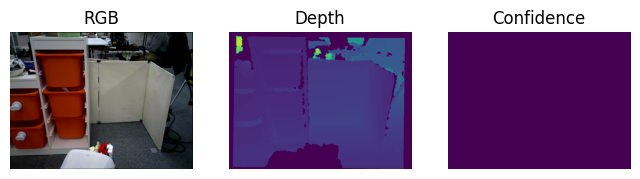

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(8, 3))

titles = ["RGB", "Depth", "Confidence"]
for ax, data, title in zip(axes, (dataset.__getitem__(0)['rgb'], dataset.__getitem__(0)['depth'], dataset.__getitem__(0)['conf']), titles):
    ax.imshow(data)
    ax.axis("off")
    ax.set_title(title)



In [8]:
from dataloaders import DeticDenseLabelledDataset

In [9]:
labelled_dataset = DeticDenseLabelledDataset(
    dataset, 
    use_extra_classes=False, 
    exclude_gt_images=False, 
    use_lseg=False, 
    subsample_prob=0.01, 
    visualize_results=True, 
    detic_threshold=0.4,
    visualization_path="detic_labelled_results",
)

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 43.6MiB/s]
INFO - 2023-06-13 05:02:22,206 - SentenceTransformer - Load pretrained SentenceTransformer: all-mpnet-base-v2


INFO - 2023-06-13 05:02:36,462 - SentenceTransformer - Use pytorch device: cuda
/root/anaconda3/envs/cf/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO - 2023-06-13 05:02:44,782 - file_io - Downloading https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...
INFO - 2023-06-13 05:02:44,785 - download - Downloading from https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...
Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth: 702MB [00:07, 96.2MB/s]                                                   
INFO - 2023-06-13 05:02:52,088 - download - Successfully downloaded /root/.torch/iopath_cache/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth. 

Loading pretrained CLIP


Calculating Detic features:   0%|                                                                          | 0/48 [00:00<?, ?it/s]

torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:   2%|█▍                                                                | 1/48 [00:04<03:33,  4.55s/it]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:   4%|██▊                                                               | 2/48 [00:05<01:39,  2.17s/it]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:   6%|████▏                                                             | 3/48 [00:05<01:04,  1.44s/it]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:   8%|█████▌                                                            | 4/48 [00:05<00:43,  1.00it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  12%|████████▎                                                         | 6/48 [00:06<00:23,  1.76it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  15%|█████████▋                                                        | 7/48 [00:06<00:21,  1.90it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  17%|███████████                                                       | 8/48 [00:06<00:17,  2.23it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  19%|████████████▍                                                     | 9/48 [00:07<00:17,  2.20it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  21%|█████████████▌                                                   | 10/48 [00:07<00:14,  2.53it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  23%|██████████████▉                                                  | 11/48 [00:08<00:15,  2.31it/s]

torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  25%|████████████████▎                                                | 12/48 [00:08<00:14,  2.43it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  27%|█████████████████▌                                               | 13/48 [00:08<00:12,  2.86it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  29%|██████████████████▉                                              | 14/48 [00:09<00:13,  2.60it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  31%|████████████████████▎                                            | 15/48 [00:09<00:13,  2.49it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  33%|█████████████████████▋                                           | 16/48 [00:09<00:11,  2.74it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  35%|███████████████████████                                          | 17/48 [00:10<00:11,  2.79it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  38%|████████████████████████▍                                        | 18/48 [00:10<00:09,  3.06it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  40%|█████████████████████████▋                                       | 19/48 [00:10<00:09,  3.06it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  42%|███████████████████████████                                      | 20/48 [00:11<00:09,  2.91it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])

Calculating Detic features:  44%|████████████████████████████▍                                    | 21/48 [00:11<00:09,  2.87it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  46%|█████████████████████████████▊                                   | 22/48 [00:11<00:08,  2.94it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  48%|███████████████████████████████▏                                 | 23/48 [00:12<00:08,  3.02it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  50%|████████████████████████████████▌                                | 24/48 [00:12<00:08,  2.91it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  52%|█████████████████████████████████▊                               | 25/48 [00:13<00:07,  2.88it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  54%|███████████████████████████████████▏                             | 26/48 [00:13<00:07,  2.75it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  56%|████████████████████████████████████▌                            | 27/48 [00:13<00:07,  2.79it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  58%|█████████████████████████████████████▉                           | 28/48 [00:14<00:07,  2.78it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  60%|███████████████████████████████████████▎                         | 29/48 [00:14<00:06,  2.86it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  62%|████████████████████████████████████████▋                        | 30/48 [00:15<00:09,  1.99it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  65%|█████████████████████████████████████████▉                       | 31/48 [00:15<00:07,  2.28it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  67%|███████████████████████████████████████████▎                     | 32/48 [00:15<00:06,  2.45it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  69%|████████████████████████████████████████████▋                    | 33/48 [00:16<00:05,  2.64it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  71%|██████████████████████████████████████████████                   | 34/48 [00:16<00:05,  2.70it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  73%|███████████████████████████████████████████████▍                 | 35/48 [00:16<00:04,  2.93it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  75%|████████████████████████████████████████████████▊                | 36/48 [00:17<00:04,  2.58it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  77%|██████████████████████████████████████████████████               | 37/48 [00:17<00:04,  2.51it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  79%|███████████████████████████████████████████████████▍             | 38/48 [00:18<00:03,  2.71it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  81%|████████████████████████████████████████████████████▊            | 39/48 [00:18<00:03,  2.93it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  83%|██████████████████████████████████████████████████████▏          | 40/48 [00:18<00:02,  3.27it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  85%|███████████████████████████████████████████████████████▌         | 41/48 [00:19<00:02,  2.78it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  88%|████████████████████████████████████████████████████████▉        | 42/48 [00:19<00:02,  2.91it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  90%|██████████████████████████████████████████████████████████▏      | 43/48 [00:19<00:01,  2.93it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features:  92%|███████████████████████████████████████████████████████████▌     | 44/48 [00:20<00:01,  2.79it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  94%|████████████████████████████████████████████████████████████▉    | 45/48 [00:20<00:01,  2.51it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Calculating Detic features:  96%|██████████████████████████████████████████████████████████████▎  | 46/48 [00:20<00:00,  2.59it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])

Calculating Detic features:  98%|███████████████████████████████████████████████████████████████▋ | 47/48 [00:21<00:00,  2.71it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([1, 3, 480, 640])
torch.Size([1, 307200, 3])


Calculating Detic features: 100%|█████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.16it/s]

torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size([307200])
torch.Size([307200, 3])
torch.Size

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

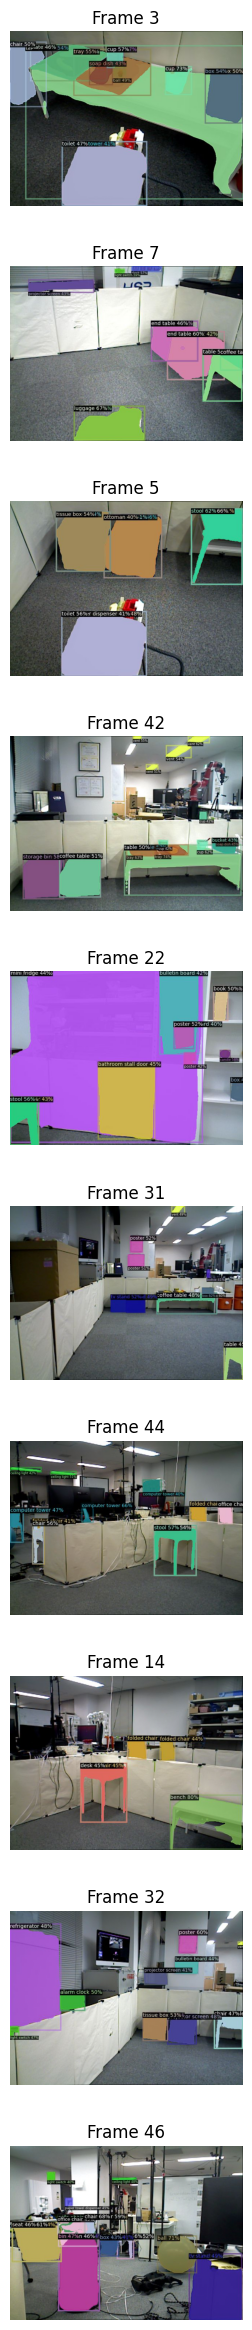

In [10]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

NUM_IMAGES = 10
TOTAL_FRAMES = glob.glob("detic_labelled_results/*.jpg")
fig, axes = plt.subplots(NUM_IMAGES, 1, figsize=(3, 3 * NUM_IMAGES))

for ax, data in zip(axes, range(NUM_IMAGES)):
    random_index = np.random.randint(0, len(TOTAL_FRAMES))
    ax.imshow(Image.open(TOTAL_FRAMES[random_index]))
    ax.axis("off")
    ax.set_title(f"Frame {random_index}")

In [11]:
import torch
torch.save(labelled_dataset, "../detic_labeled_dataset.pt")

In [12]:
import logging
import os
import pprint
import random
from typing import Dict, Union

import hydra
import numpy as np
import torch
import torch.nn.functional as F
import torchmetrics
import tqdm
from omegaconf import OmegaConf
from torch.utils.data import DataLoader, Subset

import wandb
import sys
sys.path.append('..')

In [13]:
from dataloaders import (
    R3DSemanticDataset,
    DeticDenseLabelledDataset,
    ClassificationExtractor,
)
from misc import ImplicitDataparallel
from grid_hash_model import GridCLIPModel

In [14]:
# Set up the constants

SAVE_DIRECTORY = "../clip_implicit_model"
DEVICE = "cuda"
IMAGE_TO_LABEL_CLIP_LOSS_SCALE = 1.0
LABEL_TO_IMAGE_LOSS_SCALE = 1.0
EXP_DECAY_COEFF = 0.5
SAVE_EVERY = 5
METRICS = {
    "accuracy": torchmetrics.Accuracy,
}

BATCH_SIZE = 11000
NUM_WORKERS = 10

CLIP_MODEL_NAME = "ViT-B/32"
SBERT_MODEL_NAME = "all-mpnet-base-v2"

In [15]:
# Load the data and create the dataloader created in the previous tutorial notebook

training_data = torch.load("../detic_labeled_dataset.pt")
max_coords, _ = training_data._label_xyz.max(dim=0)
min_coords, _ = training_data._label_xyz.min(dim=0)

In [16]:
# Set up the model

label_model = GridCLIPModel(
    image_rep_size=training_data[0]["clip_image_vector"].shape[-1],
    text_rep_size=training_data[0]["clip_vector"].shape[-1],
    mlp_depth=1,
    mlp_width=600,
    log2_hashmap_size=20,
    num_levels=18,
    level_dim=8,
    per_level_scale=2,
    max_coords=max_coords,
    min_coords=min_coords,
).to(DEVICE)

In [17]:
@torch.no_grad()
def zero_shot_eval(
    classifier: ClassificationExtractor, 
    predicted_label_latents: torch.Tensor, 
    predicted_image_latents: torch.Tensor, 
    language_label_index: torch.Tensor, 
    metric_calculators: Dict[str, Dict[str, torchmetrics.Metric]]
):
    """Evaluate the model on the zero-shot classification task."""
    class_probs = classifier.calculate_classifications(
        model_text_features=predicted_label_latents,
        model_image_features=predicted_image_latents,
    )
    # Now figure out semantic accuracy and loss.
    # Semseg mask is necessary for the boundary case where all the points in the batch are "unlabeled"
    semseg_mask = torch.logical_and(
        language_label_index != -1,
        language_label_index < classifier.total_label_classes,
    ).squeeze(-1)
    if not torch.any(semseg_mask):
        classification_loss = torch.zeros_like(semseg_mask).mean(dim=-1)
    else:
        # Figure out the right classes.
        masked_class_prob = class_probs[semseg_mask]
        masked_labels = language_label_index[semseg_mask].squeeze(-1).long()
        classification_loss = F.cross_entropy(
            torch.log(masked_class_prob),
            masked_labels,
        )
        if metric_calculators.get("semantic"):
            for _, calculators in metric_calculators["semantic"].items():
                _ = calculators(masked_class_prob, masked_labels)
    return classification_loss

In [26]:
def train(
    clip_train_loader: DataLoader,
    labelling_model: Union[GridCLIPModel, ImplicitDataparallel],
    optim: torch.optim.Optimizer,
    epoch: int,
    classifier: ClassificationExtractor,
    device: Union[str, torch.device] = DEVICE,
    exp_decay_coeff: float = EXP_DECAY_COEFF,
    image_to_label_loss_ratio: float = IMAGE_TO_LABEL_CLIP_LOSS_SCALE,
    label_to_image_loss_ratio: float = LABEL_TO_IMAGE_LOSS_SCALE,
    disable_tqdm: bool = False,
    metric_calculators: Dict[str, Dict[str, torchmetrics.Metric]] = {},
):
    """
    Train the model for one epoch.
    """
    total_loss = 0
    label_loss = 0
    image_loss = 0
    classification_loss = 0
    total_samples = 0
    total_classification_loss = 0
    labelling_model.train()
    total = len(clip_train_loader)
    for clip_data_dict in tqdm.tqdm(
        clip_train_loader,
        total=total,
        disable=disable_tqdm,
        desc=f"Training epoch {epoch}",
    ):
        xyzs = clip_data_dict["xyz"].to(device)
        clip_labels = clip_data_dict["clip_vector"].to(device)
        clip_image_labels = clip_data_dict["clip_image_vector"].to(device)
        image_weights = torch.exp(-exp_decay_coeff * clip_data_dict["distance"]).to(
            device
        )
        label_weights = clip_data_dict["semantic_weight"].to(device)
        image_label_index: torch.Tensor = (
            clip_data_dict["img_idx"].to(device).reshape(-1, 1)
        )
        language_label_index: torch.Tensor = (
            clip_data_dict["label"].to(device).reshape(-1, 1)
        )

        (predicted_label_latents, predicted_image_latents) = labelling_model(xyzs)
        # Calculate the loss from the image to label side.
        batch_size = len(image_label_index)
        image_label_mask: torch.Tensor = (
            image_label_index != image_label_index.t()
        ).float() + torch.eye(batch_size, device=device)
        language_label_mask: torch.Tensor = (
            language_label_index != language_label_index.t()
        ).float() + torch.eye(batch_size, device=device)

        # For logging purposes, keep track of negative samples per point.
        image_label_mask.requires_grad = False
        language_label_mask.requires_grad = False
        contrastive_loss_labels = labelling_model.compute_loss(
            predicted_label_latents,
            clip_labels,
            label_mask=language_label_mask,
            weights=label_weights,
        )
        contrastive_loss_images = labelling_model.compute_loss(
            predicted_image_latents,
            clip_image_labels,
            label_mask=image_label_mask,
            weights=image_weights,
        )
        del (
            image_label_mask,
            image_label_index,
            language_label_mask,
        )

        # Mostly for evaluation purposes, calculate the classification loss.
        classification_loss = zero_shot_eval(
            classifier, predicted_label_latents, predicted_image_latents, language_label_index, metric_calculators
        )

        contrastive_loss = (
            image_to_label_loss_ratio * contrastive_loss_images
            + label_to_image_loss_ratio * contrastive_loss_labels
        )

        optim.zero_grad(set_to_none=True)
        contrastive_loss.backward()
        optim.step()
        # Clip the temperature term for stability
        labelling_model.temperature.data = torch.clamp(
            labelling_model.temperature.data, max=np.log(100.0)
        )
        label_loss += contrastive_loss_labels.detach().cpu().item()
        image_loss += contrastive_loss_images.detach().cpu().item()
        total_classification_loss += classification_loss.detach().cpu().item()
        total_loss += contrastive_loss.detach().cpu().item()
        total_samples += 1

    to_log = {
        "train_avg/contrastive_loss_labels": label_loss / total_samples,
        "train_avg/contrastive_loss_images": image_loss / total_samples,
        "train_avg/semseg_loss": total_classification_loss / total_samples,
        "train_avg/loss_sum": total_loss / total_samples,
        "train_avg/labelling_temp": torch.exp(labelling_model.temperature.data.detach())
        .cpu()
        .item(),
    }
    for metric_dict in metric_calculators.values():
        for metric_name, metric in metric_dict.items():
            try:
                to_log[f"train_avg/{metric_name}"] = (
                    metric.compute().detach().cpu().item()
                )
            except RuntimeError as e:
                to_log[f"train_avg/{metric_name}"] = 0.0
            metric.reset()
    logging.debug(pprint.pformat(to_log, indent=4, width=1))
    return total_loss

In [27]:
def save(
    labelling_model: Union[ImplicitDataparallel, GridCLIPModel],
    optim: torch.optim.Optimizer,
    epoch: int,
    save_directory: str = SAVE_DIRECTORY,
    saving_dataparallel: bool = False,
):
    if saving_dataparallel:
        to_save = labelling_model.module
    else:
        to_save = labelling_model
    state_dict = {
        "model": to_save.state_dict(),
        "optim": optim.state_dict(),
        "epoch": epoch,
    }
    torch.save(
        state_dict,
        f"{save_directory}/implicit_scene_label_model_latest.pt",
    )
    return 0

In [28]:
train_classifier = ClassificationExtractor(
    clip_model_name=CLIP_MODEL_NAME,
    sentence_model_name=SBERT_MODEL_NAME,
    class_names=training_data._all_classes,
    device=DEVICE,
)

INFO - 2023-06-13 05:06:26,407 - SentenceTransformer - Load pretrained SentenceTransformer: all-mpnet-base-v2


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [29]:
# Set up our metrics on this dataset.
train_metric_calculators = {}
train_class_count = {"semantic": train_classifier.total_label_classes}
average_style = ["micro", "macro", "weighted"]
for classes, counts in train_class_count.items():
    train_metric_calculators[classes] = {}
    for metric_name, metric_cls in METRICS.items():
        for avg in average_style:
            if "accuracy" in metric_name:
                new_metric = metric_cls(
                    num_classes=counts, average=avg, multiclass=True
                ).to(DEVICE)
                train_metric_calculators[classes][
                    f"{classes}_{metric_name}_{avg}"
                ] = new_metric


In [30]:
# No dataparallel for now
batch_multiplier = 1

clip_train_loader = DataLoader(
    training_data,
    batch_size=batch_multiplier * BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)
logging.debug(f"Total train dataset sizes: {len(training_data)}")

In [31]:
# Set up optimizer

optim = torch.optim.Adam(
    label_model.parameters(),
    lr=1e-4,
    betas=(0.9, 0.999),
    weight_decay=0.003,
)

In [33]:
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Just to reduce excessive logging from sbert

epoch = 0
NUM_EPOCHS = 5

while epoch <= NUM_EPOCHS:
    train(
        clip_train_loader,
        label_model,
        optim,
        epoch,
        train_classifier,
        metric_calculators=train_metric_calculators,
    )
    epoch += 1
    if epoch % SAVE_EVERY == 0:
        save(label_model, optim, epoch)

Training epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.99it/s]


In [34]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain, cycle
from sentence_transformers import SentenceTransformer, util

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import tqdm
import einops

import os
import sys
sys.path.append("../") # add parent directory to path

In [35]:
%matplotlib inline
from dataloaders.real_dataset import DeticDenseLabelledDataset
from grid_hash_model import GridCLIPModel

from misc import MLP

In [36]:
import pandas as pd
import pyntcloud
from pyntcloud import PyntCloud
import clip

DEVICE = "cuda"
model, preprocess = clip.load("ViT-B/32", device=DEVICE)
sentence_model = SentenceTransformer("all-mpnet-base-v2")

INFO - 2023-06-13 05:08:16,384 - SentenceTransformer - Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO - 2023-06-13 05:08:17,983 - SentenceTransformer - Use pytorch device: cuda


In [37]:
training_data = torch.load("../detic_labeled_dataset.pt")
max_coords, _ = training_data._label_xyz.max(dim=0)
min_coords, _ = training_data._label_xyz.min(dim=0)

In [38]:
label_model = GridCLIPModel(
    image_rep_size=training_data[0]["clip_image_vector"].shape[-1],
    text_rep_size=training_data[0]["clip_vector"].shape[-1],
    mlp_depth=1,
    mlp_width=600,
    log2_hashmap_size=20,
    num_levels=18,
    level_dim=8,
    per_level_scale=2,
    max_coords=max_coords,
    min_coords=min_coords,
).to(DEVICE)

model_weights_path = "../clip_implicit_model/implicit_scene_label_model_latest.pt"
model_weights = torch.load(model_weights_path, map_location=DEVICE)
label_model.load_state_dict(model_weights["model"])
print(label_model)
print("Loaded model from", model_weights_path)

GridCLIPModel(
  (_grid_model): GridEncoder: input_dim=3 num_levels=18 level_dim=8 resolution=16 -> 2097152 per_level_scale=2.0000 params=(16044136, 8) gridtype=hash align_corners=False
  (_post_grid): MLP(
    (trunk): Sequential(
      (0): Linear(in_features=144, out_features=600, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=600, out_features=1280, bias=True)
    )
  )
  (_image_head): Identity()
)
Loaded model from ../clip_implicit_model/implicit_scene_label_model_latest.pt


In [39]:
batch_size = 30_000
points_dataloader = DataLoader(
    training_data._label_xyz, batch_size=batch_size, num_workers=10,
)
print("Created data loader", points_dataloader)

Created data loader <torch.utils.data.dataloader.DataLoader object at 0x7f9434be5e80>


In [40]:
def calculate_clip_and_st_embeddings_for_queries(queries):
    all_clip_queries = clip.tokenize(queries)
    with torch.no_grad():
        all_clip_tokens = model.encode_text(all_clip_queries.to(DEVICE)).float()
        all_clip_tokens = F.normalize(all_clip_tokens, p=2, dim=-1)
        all_st_tokens = torch.from_numpy(sentence_model.encode(queries))
        all_st_tokens = F.normalize(all_st_tokens, p=2, dim=-1).to(DEVICE)
    return all_clip_tokens, all_st_tokens

query = "Warm up my lunch"
clip_text_tokens, st_text_tokens = calculate_clip_and_st_embeddings_for_queries([query])
print("query =", query)
print("tokens shape =", clip_text_tokens.shape)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

query = Warm up my lunch
tokens shape = torch.Size([1, 512])


In [41]:
def find_alignment_over_model(label_model, queries, dataloader, visual=False):
    clip_text_tokens, st_text_tokens = calculate_clip_and_st_embeddings_for_queries(queries)
    # We give different weights to visual and semantic alignment 
    # for different types of queries.
    if visual:
        vision_weight = 10.0
        text_weight = 1.0
    else:
        vision_weight = 1.0
        text_weight = 10.0
    point_opacity = []
    with torch.no_grad():
        for data in tqdm.tqdm(dataloader, total=len(dataloader)):
            # Find alignmnents with the vectors
            predicted_label_latents, predicted_image_latents = label_model(data.to(DEVICE))
            data_text_tokens = F.normalize(predicted_label_latents, p=2, dim=-1).to(DEVICE)
            data_visual_tokens = F.normalize(predicted_image_latents, p=2, dim=-1).to(DEVICE)
            text_alignment = data_text_tokens @ st_text_tokens.T
            visual_alignment = data_visual_tokens @ clip_text_tokens.T
            total_alignment = (text_weight * text_alignment) + (vision_weight * visual_alignment)
            total_alignment /= (text_weight + vision_weight)
            point_opacity.append(total_alignment)

    point_opacity = torch.cat(point_opacity).T
    print(point_opacity.shape)
    return point_opacity


In [42]:
merged_pcd = o3d.geometry.PointCloud()
merged_pcd.points = o3d.utility.Vector3dVector(training_data._label_xyz)
merged_pcd.colors = o3d.utility.Vector3dVector(training_data._label_rgb)
merged_downpcd = merged_pcd.voxel_down_sample(voxel_size=0.03)

print("Create pts result")
pts_result = np.concatenate((np.asarray(merged_downpcd.points), np.asarray(merged_downpcd.colors)), axis=-1)

df = pd.DataFrame(
    # same arguments that you are passing to visualize_pcl
    data=pts_result,
    columns=["x", "y", "z", "red", "green", "blue"]
)
cloud = PyntCloud(df)

print("Point cloud", cloud)

Create pts result
Point cloud PyntCloud
36889 points with 3 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 1.7620961775559334, 3.4446514634712977, 0.7420712910229291
Other attributes:



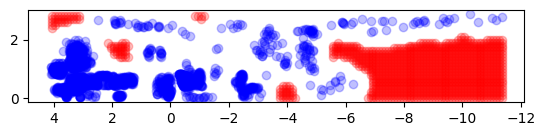

Found some valid points: (1049, 2)


In [43]:
# Now figure out the points that are far enough.
coordinates = cloud.points
coordinates = coordinates[coordinates.y < 0]

# This is the cutoff used for NYU kitchen
CUTOFF = 0.65

# Make a top down map for visualization. This step works best if the data is axis aligned.
def get_and_show_valid_points(coordinates, cutoff=CUTOFF, library=True):
    blockers = np.array([coordinates.x, coordinates.z]).T
    all_grid_points = np.array(np.meshgrid(np.arange(coordinates.x.min(), coordinates.x.max(), 0.1), np.arange(coordinates.z.min(), coordinates.z.max(), 0.1))).reshape(2, -1).T
    distance = np.linalg.norm(blockers[None, :, :] - all_grid_points[:, None, :], axis=2, ord=2)

    valid_points_index = distance.min(axis=1) > cutoff
    valid_points = all_grid_points[valid_points_index]

    ax = plt.subplot(111)
    ax.scatter(coordinates.x, coordinates.z, c="blue", alpha=0.25)
    ax.scatter(valid_points[:, 0], valid_points[:, 1], c="red", alpha = 0.25)
    ax.invert_xaxis()
    ax.set_aspect('equal', 'box')
    plt.show()
    return valid_points

valid_points = get_and_show_valid_points(coordinates)
print("Found some valid points:", valid_points.shape)


In [44]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

queries = [
    # Literal
    "Stack of plates",
    "microwave",
    "the fridghe",  # intentional misspelling
    "coffee machine",
    "sink",

    # Visual
    # "white ceramic bowl",
    # "red plastic bowl",
    # "red coffee machine",
    # "espresso machine",
    # "blue garbage bin",
    # "potted plant in a black pot",
    # "purple poster",
    # "toaster oven",

    # Semantic
    "wash my dishes",
    "wash my hand",
    "throw my trash",
    "store my food",
    "put away my leftovers",
    "fill out water bottle",
    "make some coffee",
    "warm up my lunch",
]
# TODO: change to visual = True for visual queries.
visual = False
alignment_q = find_alignment_over_model(label_model, queries, points_dataloader, visual=visual)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]

torch.Size([13, 95621])


torch.Size([95621])


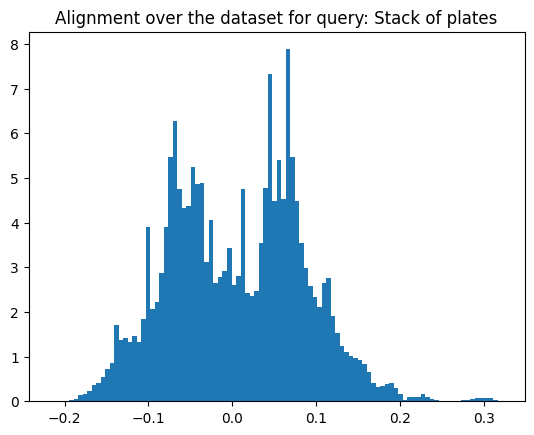

In [45]:
fig = plt.figure()
q = alignment_q[0].squeeze()
print(q.shape)
alpha = q.detach().cpu().numpy()
plt.hist(alpha, 100, density=True)
plt.title(f"Alignment over the dataset for query: {queries[0]}")

plt.show()

In [46]:
os.makedirs("visualized_pointcloud", exist_ok=True)

max_points = []
max_points_goto = []
mean_points = []
mean_point_goto = []
use_threshold = True
for query, q in zip(queries, alignment_q):
    alpha = q.detach().cpu().numpy()
    pts = training_data._label_xyz.detach().cpu()

    # We are thresholding the points to get the top 0.01% of points.
    # Subsample if the number of points is too large.
    threshold = torch.quantile(q[::10, ...], 0.9999).cpu().item()

    # Normalize alpha
    a_norm = (alpha - alpha.min()) / (alpha.max() - alpha.min())
    a_norm = torch.as_tensor(a_norm[..., np.newaxis])
    all_colors = torch.cat((a_norm, torch.zeros_like(a_norm), 1-a_norm), dim=1)

    if use_threshold:
        thres = alpha > threshold
        points = training_data._label_xyz[thres]
        max_point = pts[torch.argmax(a_norm)]
        max_points.append(max_point)
        print(f"LOOKAT {query} {max_point.tolist()}")
        colors = all_colors[thres]
    else:
        points = training_data._label_xyz
        colors = all_colors
    merged_pcd = o3d.geometry.PointCloud()
    merged_pcd.points = o3d.utility.Vector3dVector(points)
    merged_pcd.colors = o3d.utility.Vector3dVector(colors)
    merged_downpcd = merged_pcd.voxel_down_sample(voxel_size=0.01)
    visual_str = "_visual" if visual else ""
    thres_str = "_thres" if use_threshold else ""
    o3d.io.write_point_cloud(f"visualized_pointcloud/model_nyu_kitchen_{query}{visual_str}{thres_str}.ply", merged_downpcd)

LOOKAT Stack of plates [2.5369129180908203, 0.23962432146072388, 0.4222944974899292]
LOOKAT microwave [4.070383071899414, 2.155723810195923, 0.7118257880210876]
LOOKAT the fridghe [0.7878122329711914, 6.048222541809082, 0.9896724224090576]
LOOKAT coffee machine [-0.43323591351509094, 0.37067699432373047, 0.37899157404899597]
LOOKAT sink [2.3303377628326416, 0.2668665647506714, 0.5120404958724976]
LOOKAT wash my dishes [2.212048053741455, 0.209400475025177, 0.4492388367652893]
LOOKAT wash my hand [3.5847270488739014, 0.8068898916244507, 0.017274776473641396]
LOOKAT throw my trash [3.8086421489715576, 5.818597316741943, 0.07912702858448029]
LOOKAT store my food [1.7653204202651978, 0.02660505846142769, 0.4890422821044922]
LOOKAT put away my leftovers [0.5819554924964905, 5.50282096862793, 0.3746085464954376]
LOOKAT fill out water bottle [-0.4181898832321167, 0.4208548069000244, 0.716806173324585]
LOOKAT make some coffee [3.869044780731201, 0.12807710468769073, 0.3112471401691437]
LOOKAT 

In [47]:
from pyntcloud.plot.common import get_colors

from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.cm as cm


def set_proper_aspect_ratio(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

def plot_with_matplotlib(cloud, 
            **kwargs):

    colors = get_colors(cloud, kwargs["use_as_color"], kwargs["cmap"])

    ptp = cloud.xyz.ptp()

    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.view_init(elev=kwargs.get("elev", 0.0), azim=kwargs.get("azim", 90.0))

    ax.scatter(
        cloud.xyz[:, 0],
        cloud.xyz[:, 1],
        cloud.xyz[:, 2],
        marker="D",
        facecolors=colors / 255,
        alpha=0.25,
        zdir="z",
        depthshade=True,
        s=kwargs["initial_point_size"] or ptp / 10
    )


    if "text" in kwargs:
        for i, (points, text) in enumerate(kwargs["text"]):
            ax.text(points[0], points[1], points[2], text)

    if "title" in kwargs:
        ax.set_title(kwargs["title"])
    
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    set_proper_aspect_ratio(ax)

    return plt.show()

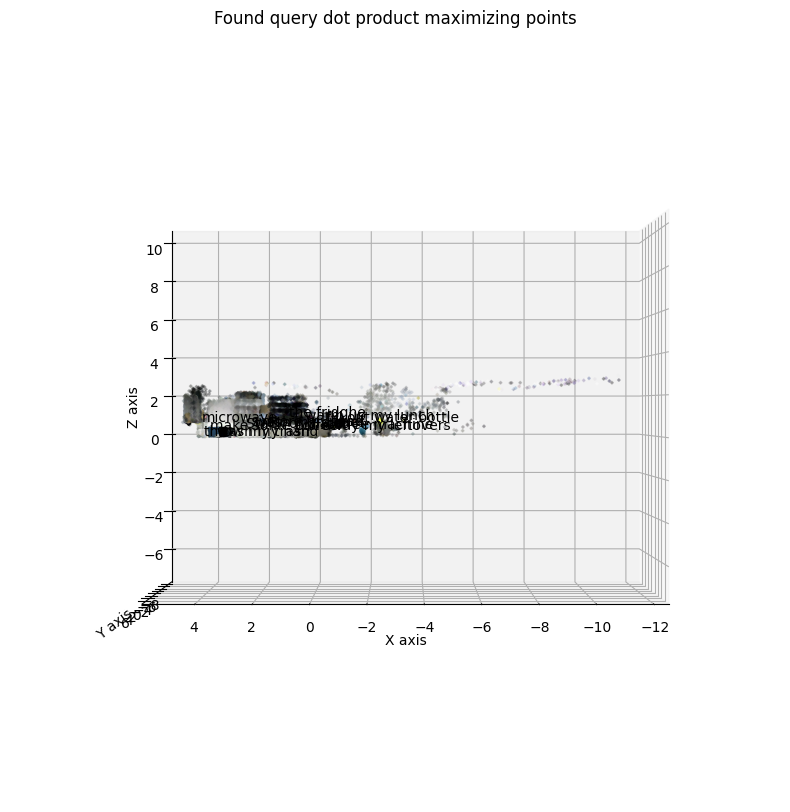

In [48]:
plot_with_matplotlib(
    cloud,
    width=800,
    height=500,
    background="black",
    mesh=False,
    use_as_color=["red", "green", "blue"],
    initial_point_size=None,
    cmap="hsv",
    polylines=None,
    linewidth=5,
    return_scene=False,
    output_name="pyntcloud_plot",
    elev=0.,
    azim=90.,
    text=zip(max_points, queries),
    title="Found query dot product maximizing points",
    goto=max_points_goto,
)